In [ ]:
!pip install bayesian-torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [ ]:
import torch.nn.functional as F
import numpy as np

def entropy(prob):
    return -1 * np.sum(prob * np.log(prob + 1e-15), axis=-1)

def predictive_entropy(mc_preds):
    """
    Compute the entropy of the mean of the predictive distribution
    obtained from Monte Carlo sampling during prediction phase.
    """
    return entropy(np.mean(mc_preds, axis=0))


def mutual_information(mc_preds):
    """
    Compute the difference between the entropy of the mean of the
    predictive distribution and the mean of the entropy.
    """
    mutual_info = entropy(np.mean(mc_preds, axis=0)) - np.mean(entropy(mc_preds),
                                                               axis=0)
    return mutual_info

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
import h5py
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from torch.utils.data import  SubsetRandomSampler
import shutil

In [ ]:
import torch
import torchvision
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

In [ ]:
!pip install wandb
import wandb
wandb.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
def find_images_without_masks(image_dir, mask_dir):
    images = os.listdir(image_dir)
    masks = os.listdir(mask_dir)

    images_without_masks = [img for img in images if img not in masks]
    images_with_masks = [img for img in images if img in masks]

    return images_with_masks, images_without_masks

# Example usage
image_dir = r"/content/gdrive/MyDrive/data/Mixed/CXR_Png/"
mask_dir = r"/content/gdrive/MyDrive/data/Mixed/masks/"

images_with_masks, images_without_masks = find_images_without_masks(image_dir, mask_dir)
print("Images with corresponding masks:", len(images_with_masks))
print("Images without corresponding masks:", images_without_masks)
print("No. of Images without corresponding masks:", len(images_without_masks))

Images with corresponding masks: 801
Images without corresponding masks: []
No. of Images without corresponding masks: 0


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        filename = str(self.images[idx])
        mask_name = os.path.join(self.mask_dir, filename)

        try:
            image = Image.open(img_name).convert("L")  # Convert to grayscale
            mask = Image.open(mask_name).convert("L")  # Convert to grayscale

            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)

            # Check for NaN values in images or masks
            if torch.isnan(image).any() or torch.isnan(mask).any():
                print(f"NaN values encountered in image or mask at index {idx}. Skipping this sample.")
                # Return empty tensors if NaN values are encountered
                image = torch.empty((1, 128, 128))
                mask = torch.empty((1, 128, 128))

        except Exception as e:
            print(f"Error loading image or mask: {e}")
            # Return empty tensors if an error occurs
            image = torch.empty((1, 128, 128))
            mask = torch.empty((1, 128, 128))

        return {'image': image, 'mask': mask}

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create dataset
dataset = CustomDataset(image_dir, mask_dir, transform=transform)

# Get the number of samples in the dataset
num_samples = len(dataset)

# Create a random sampler with the correct number of samples
sampler = SubsetRandomSampler(range(num_samples))

# Create dataloader using the sampler
dataloader = DataLoader(dataset, batch_size=16, sampler=sampler)

In [ ]:

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):
    def __init__(self, n_class):
        super(UNet, self).__init__()

        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [ ]:
device = torch.device("cuda:0")
model = UNet(1)

# Assuming `model`, `dataloader`, and `device` are defined elsewhere
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}


dnn_to_bnn(model, const_bnn_prior_parameters)
model.to(device)

for epoch in range(20):
  for i, data in enumerate(dataloader):
          inputs, labels = data['image'].to(device), data['mask'].to(device)

          # Check for NaN values in inputs or labels
          if torch.isnan(inputs).any() or torch.isnan(labels).any():
              print(f"NaN values encountered in inputs or labels at index {i}. Skipping this iteration.")
              continue

  ##
          criterion = torch.nn.CrossEntropyLoss()
          optimizer = torch.optim.Adam(model.parameters(), 0.0001)

          output = model(inputs)
          kl = get_kl_loss(model)
          ce_loss = criterion(output, labels)
          loss = ce_loss + kl / 25

          loss.backward()
          optimizer.step()
          print(f"Epoch [{epoch+1}/{50}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}")
  ##




KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/data/AC_Mixed_Bayesian_bt_0.1.pth")
print("Finished Training")

Finished Training


In [ ]:
#define x_test and y_test
model = UNet(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.load("/content/gdrive/MyDrive/data/AC_Mixed_Bayesian_bt_0.1.pth", map_location='cpu')
new_image_path = r'/content/gdrive/My Drive/tensorflow/data/MGM/CXR_Png/MCUCXR_0393_1.png'
new_image = Image.open(new_image_path).convert("L")  # Convert to grayscale
x_test = transform(new_image).unsqueeze(0).to("cpu")
new_mask_path = r'/content/gdrive/My Drive/data/MGM/masks/MCUCXR_0369_1.png'
new_mask = Image.open(new_image_path).convert("L")  # Convert to grayscale
y_test = transform(new_image).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    output_mc = []
    for mc_run in range(50):
        logits = model(x_test)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        output_mc.append(probs)
    output = torch.stack(output_mc)
    pred_mean = output.mean(dim=0)
    y_pred = torch.argmax(pred_mean, axis=-1)
    test_acc = (y_pred.data.cpu().numpy() == y_test.data.cpu().numpy()).mean()

In [ ]:
predictive_uncertainty = predictive_entropy(output.data.cpu().numpy())
model_uncertainty = mutual_information(output.data.cpu().numpy())
print(predictive_uncertainty)
print( model_uncertainty)
print(test_acc)

[[[4.85203   4.8520293 4.852029  4.85203   4.85203   4.8520293 4.8520303
   4.85203   4.85203   4.852029  4.8520293 4.85203   4.85203   4.85203
   4.85203   4.85203   4.8520303 4.85203   4.852029  4.85203   4.85203
   4.8520303 4.8520303 4.85203   4.85203   4.85203   4.85203   4.8520293
   4.8520303 4.85203   4.85203   4.8520308 4.85203   4.85203   4.8520293
   4.85203   4.85203   4.85203   4.85203   4.8520303 4.85203   4.8520293
   4.85203   4.8520303 4.8520293 4.85203   4.85203   4.85203   4.85203
   4.85203   4.85203   4.85203   4.85203   4.85203   4.8520293 4.85203
   4.85203   4.8520293 4.85203   4.85203   4.85203   4.85203   4.85203
   4.85203   4.85203   4.8520293 4.85203   4.85203   4.85203   4.85203
   4.8520293 4.852029  4.852029  4.85203   4.852029  4.8520293 4.852029
   4.852029  4.852029  4.852029  4.852029  4.8520293 4.852029  4.852029
   4.852029  4.8520293 4.852029  4.852029  4.8520293 4.852029  4.852029
   4.852029  4.852029  4.852029  4.852029  4.852029  4.85203   4.8

NameError: name 'np' is not defined

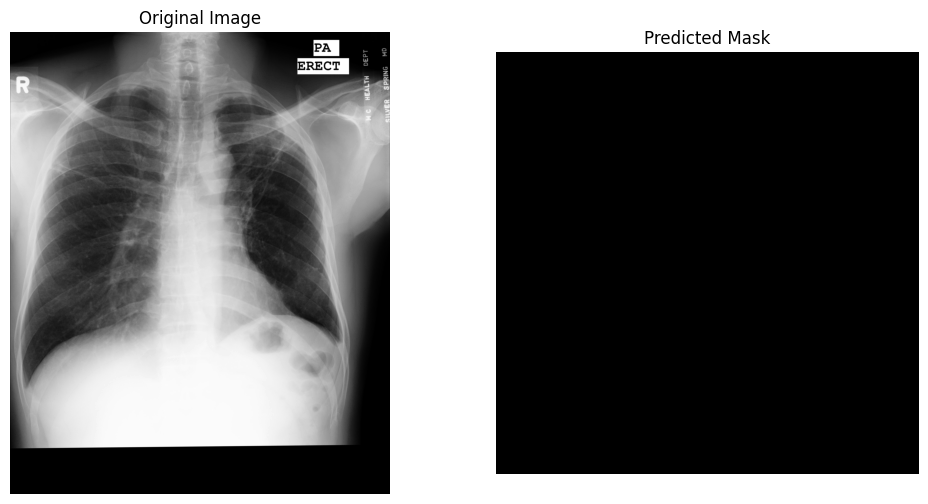

In [ ]:
checkpoint_path = r"/content/gdrive/MyDrive/data/AC_Mixed_Bayesian_bt_0.1.pth"

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()  # Set model to evaluation mode

# Load the new chest X-ray image
new_image_path = r'/content/gdrive/My Drive/tensorflow/data/MGM/CXR_Png/MCUCXR_0275_1.png'
new_image = Image.open(new_image_path).convert("L")  # Convert to grayscale
new_image_tensor = transform(new_image).unsqueeze(0).to(device)  # Preprocess and move to device

# Perform inference
with torch.no_grad():
    output_mean = model(new_image_tensor)  # Assuming model returns the mean of the output distribution

# Define a fixed standard deviation or use a learned parameter from the model
output_std = torch.ones_like(output_mean) * 0.1  # Example: using a fixed standard deviation of 0.1

# Convert output mean to probabilities using sigmoid activation
sigmoid = nn.Sigmoid()
output_probabilities = sigmoid(output_mean)

# Convert output probabilities to binary mask
threshold = 0.5
predicted_mask = (output_probabilities > threshold).float()



# Display original image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(new_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')
plt.show()